In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import galsim
import lsst.geom as geom
import numpy as np
import pytest

import xlens

from lsst.skymap.discreteSkyMap import (
    DiscreteSkyMapConfig, DiscreteSkyMap,
)

config = DiscreteSkyMapConfig()
config.projection = "TAN"
# Define tract center explicitly 
config.raList = [0.0]         # degrees
config.decList = [0.0]        # degrees
config.radiusList = [0.02]     # radius in degrees

config.rotation = 0.0         # tract rotation in degrees

# Patch and tract configuration
config.patchInnerDimensions = [1000, 1000]  # inner size of patch in pixels
config.patchBorder = 0                         # border size in pixels
config.pixelScale = 0.2                         # arcsec/pixel
config.tractOverlap = 0.0                     # no overlap
# Create the skymap
skymap = DiscreteSkyMap(config)

In [2]:
from xlens.simulator.catalog import CatalogShearTask, CatalogShearTaskConfig
from xlens.simulator.sim import (
    IASimConfig,
    IASimTask,
    MultibandSimConfig,
    MultibandSimTask,
)

tract_info = skymap[0]
catalog_config = CatalogShearTaskConfig()
catalog_config.mode = 2
catalog_config.test_value = 0.0
catalog_config.extend_ratio = 0.92
catalog_config.layout = "grid"
catalog_task = CatalogShearTask(config=catalog_config)
truth_catalog = catalog_task.run(tract_info=tract_info, seed=0).truthCatalog

In [3]:
multiband_config = MultibandSimConfig()
multiband_config.include_point_source = False
multiband_task = MultibandSimTask(config=multiband_config)
multiband_output = multiband_task.run(
    tract_info=tract_info,
    patch_id=0,
    band="i",
    seed=0,
    truthCatalog=truth_catalog,
)

ia_config = IASimConfig()
ia_config.include_point_source = False
ia_config.ia_amplitude = 0.0
ia_task = IASimTask(config=ia_config)
ia_output = ia_task.run(
    tract_info=tract_info,
    patch_id=0,
    band="i",
    seed=0,
    truthCatalog=truth_catalog,
)

multiband_image = multiband_output.simExposure.image.array
ia_image = ia_output.simExposure.image.array

diff = np.abs(multiband_image - ia_image)
baseline = np.max(np.abs(multiband_image))

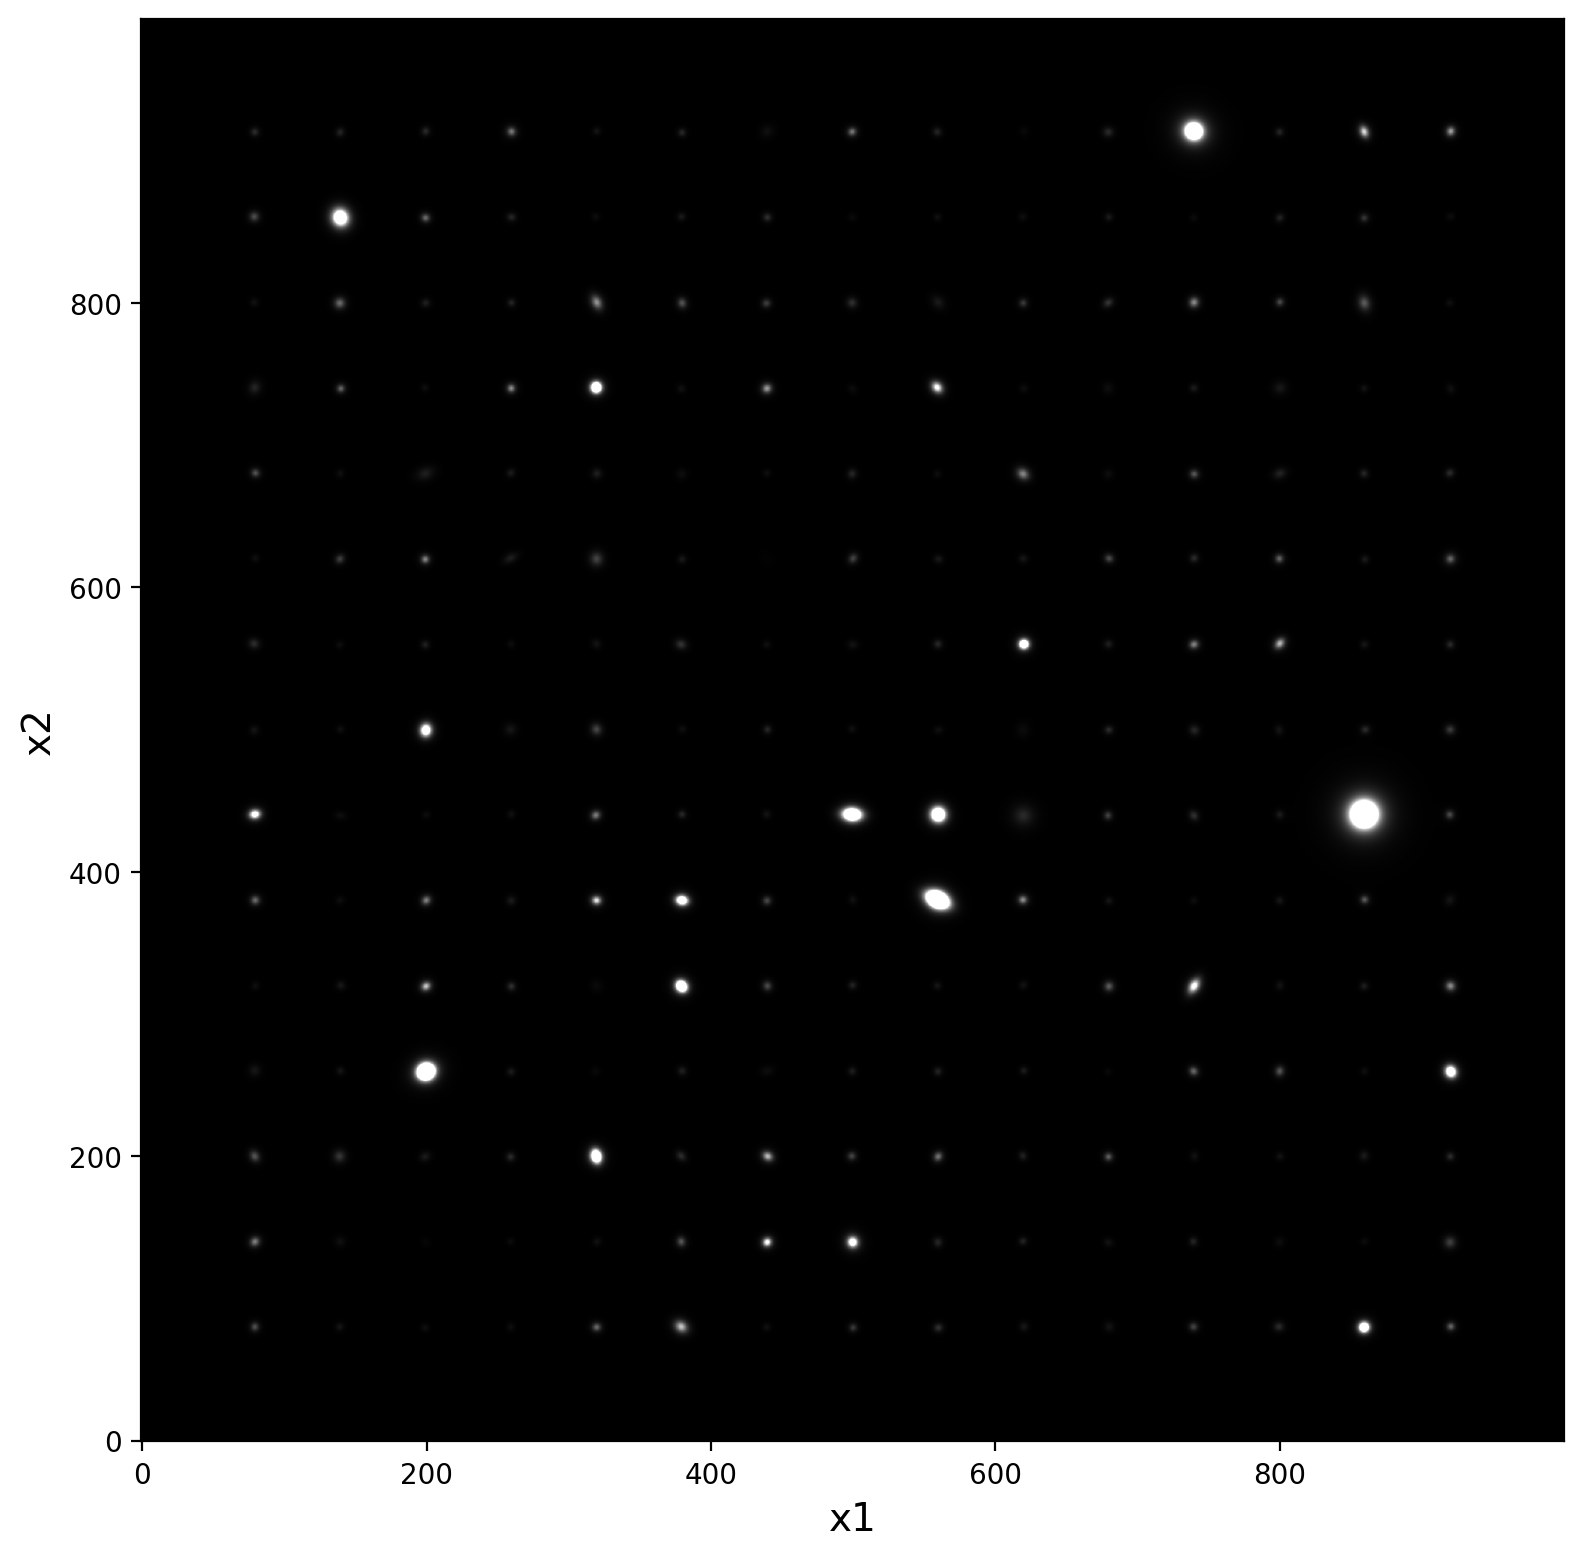

In [21]:
import matplotlib.pyplot as plt

vmin = 0.0
vmax = 5.0

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(multiband_image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.set_xlabel("x1", fontsize=14)
ax.set_ylabel("x2", fontsize=14)

plt.tight_layout()
plt.show()

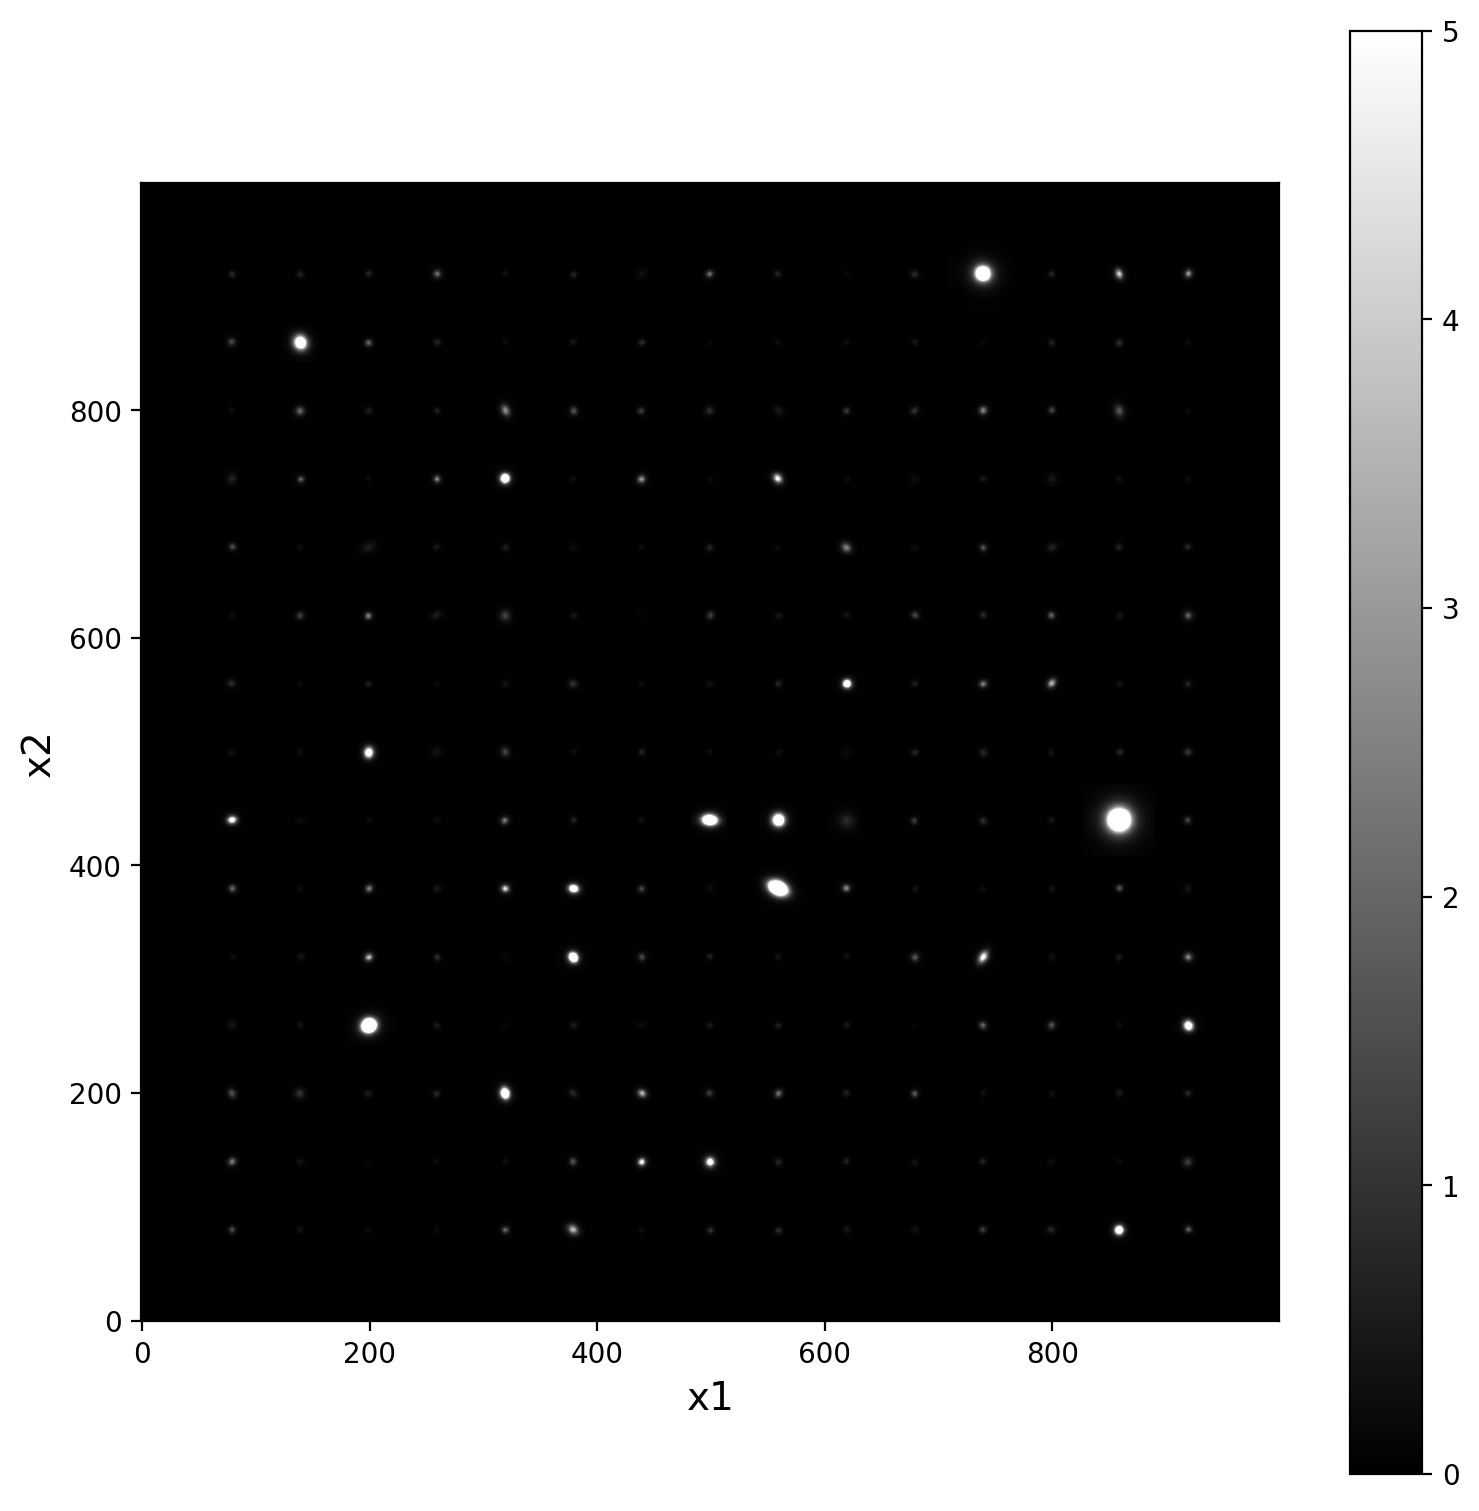

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(ia_image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.set_xlabel("x1", fontsize=14)
ax.set_ylabel("x2", fontsize=14)

plt.tight_layout()
plt.colorbar(im)
plt.show()

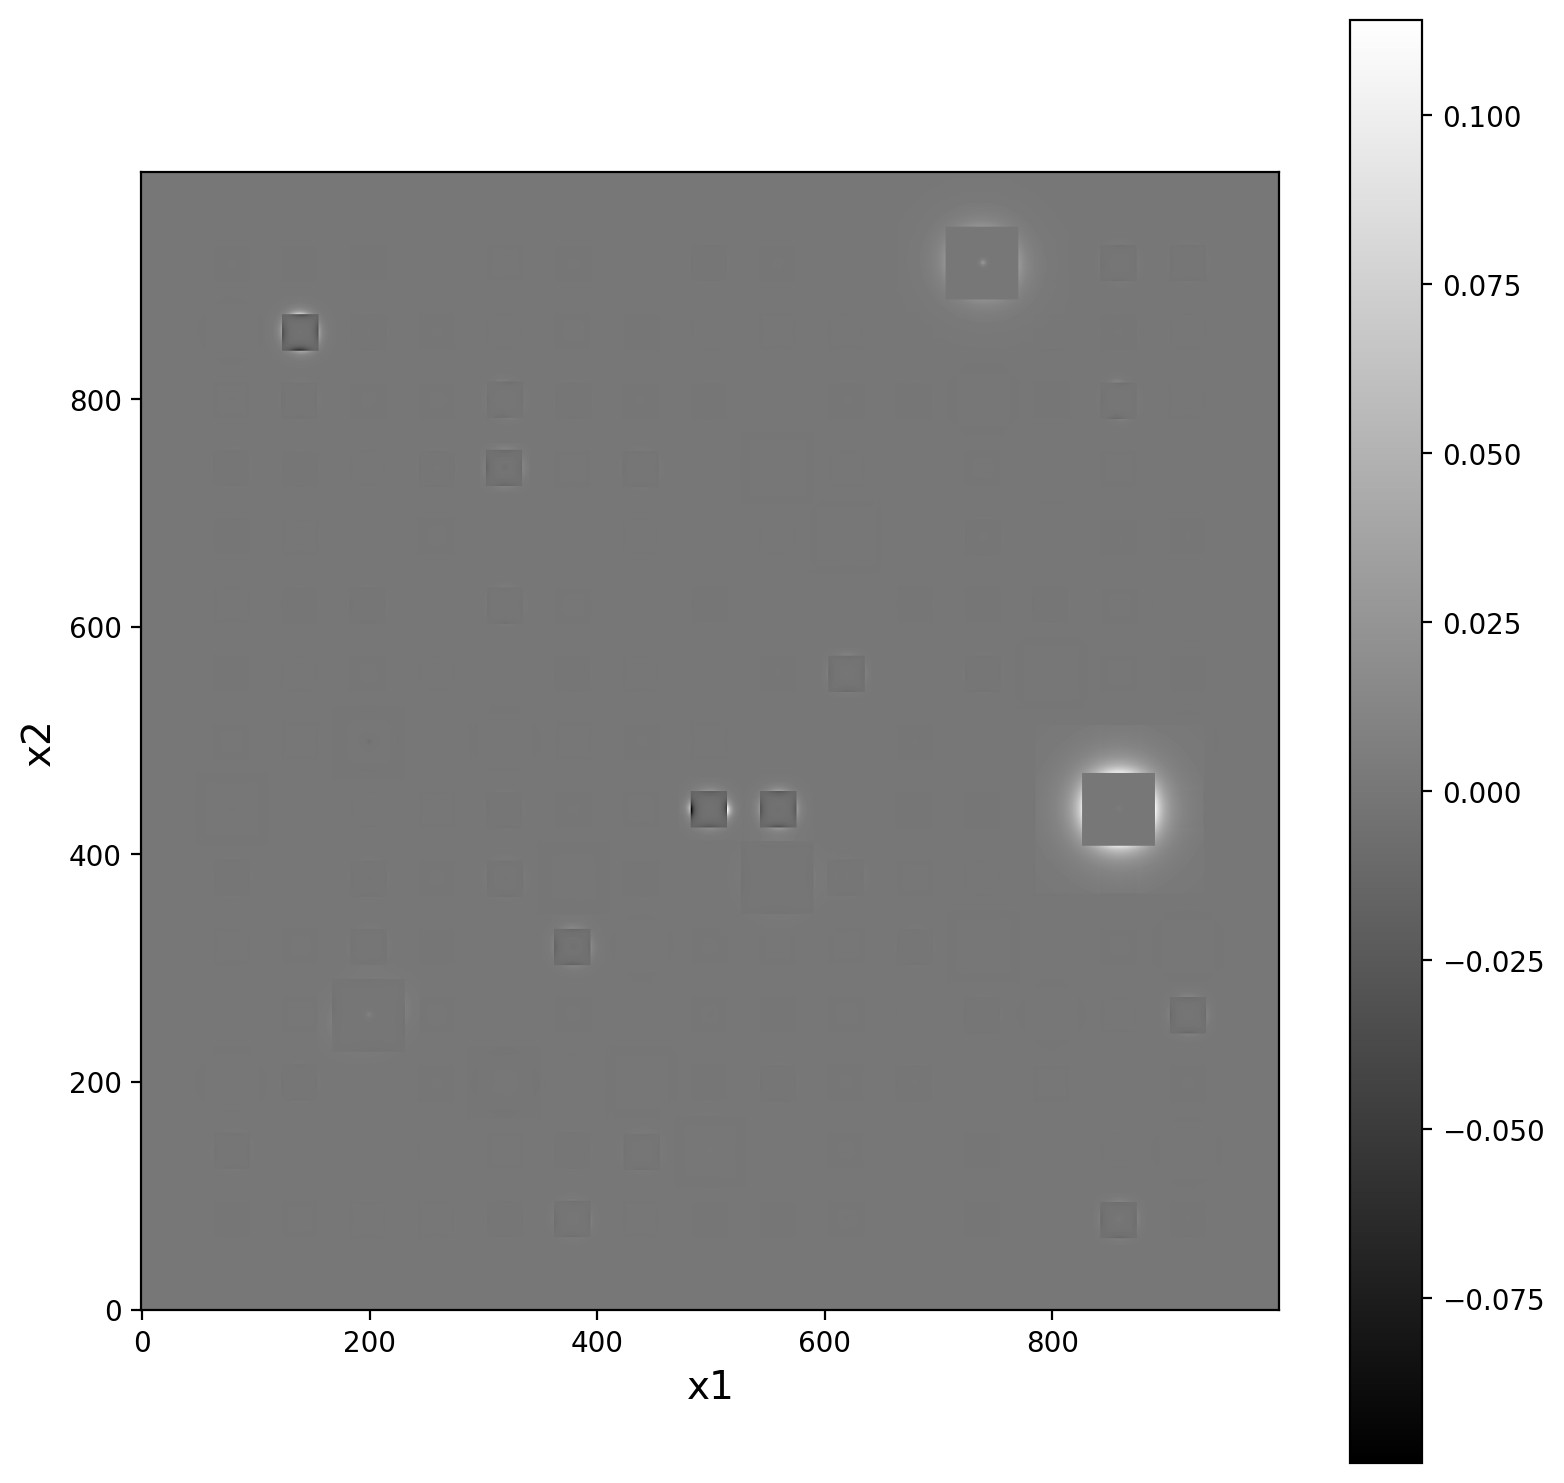

In [23]:
image = multiband_image - ia_image
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
im=ax.imshow(image, origin='lower', cmap='gray')
ax.set_xlabel("x1", fontsize=14)
ax.set_ylabel("x2", fontsize=14)

plt.tight_layout()
plt.colorbar(im)
plt.show()

In [25]:
from xlens.process_pipe.anacal_detect import (
    AnacalDetectPipeConfig, 
    AnacalDetectPipe,
)
# Configuration
config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
config.anacal.validate_psf = False
# Task and preparation
det_task = AnacalDetectPipe(config=config)
seed = 0
data = det_task.anacal.prepare_data(
    exposure=ia_output.simExposure,
    seed=seed,
    noise_corr=None,
    detection=None,
    band=None,
    skyMap=skymap,
    tract=0,
    patch=0,
)
# Run catalog
catalog = det_task.anacal.run(**data)

# Shear Estimation
# Code magnitude cut and selection bias correction

#
e1 = catalog["wsel"] * catalog["fpfs_e1"]
de1_dg1 = catalog["dwsel_dg1"] * catalog["fpfs_e1"] + catalog["wsel"] * catalog["fpfs_de1_dg1"]
print(np.sum(e1) / np.sum(de1_dg1))

e2 = catalog["wsel"] * catalog["fpfs_e2"]
de2_dg2 = catalog["dwsel_dg2"] * catalog["fpfs_e2"] + catalog["wsel"] * catalog["fpfs_de2_dg2"]
print(np.sum(e2) / np.sum(de2_dg2))

0.009651450412573663
0.03206962044188976
